In [1]:
import polars as pl
import io
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

# Scuccorese food ingredients data set
df = pl.read_parquet('hf://datasets/Scuccorese/food-ingredients-dataset/data/train-*.parquet')

In [2]:
# Removing uneccessary data
df = df.drop('ingredient', 'subcategory')
df = df.unnest("image").select(pl.col("category"), pl.col("bytes").alias("image"))

In [3]:
# Function to convert images to WEBP format
def convert_to_webp(image_bytes):
    with Image.open(io.BytesIO(image_bytes)) as im:
        # Check if the image has transparency
        if im.mode == "P":  # Palette-based (e.g., GIFs)
            im = im.convert("RGBA")
        elif im.mode != "RGB":  # For other non-RGB formats
            im = im.convert("RGB")

        # Save the image to WEBP format in memory
        output = io.BytesIO()
        im.save(output, format='WEBP')
        return output.getvalue()

# Convert all images to WEBP format
df = df.with_columns(
    pl.col("image").map_elements(convert_to_webp, return_dtype=pl.Binary)
)

df.head()

category,image
str,binary
"""vegetables""","b""RIFF\xb4\xed\x01\x00WEBPVP8\x20\xa8\xed\x01\x00\xf0\x09\x0b\x9d\x01*+\x04\x9a\x06>m4\x96G$#,\xab\xa7\xf1\xaa\xe1\x90\x0d\x89M\xdf{\x04\xb8\xfe\x1f\x03\x17\x9aq\x06\x9b!""..."
"""vegetables""","b""RIFF\xb2\x91\x01\x00WEBPVP8\x20\xa6\x91\x01\x00\xd0s\x04\x9d\x01*\x16\x02\x20\x03>m,\x92E\xa4""\xa1\x97I\xc7,@\x06\xc4\xb25\xb67\x8b\xa9\xb0#\xab07\x806G\x00""..."
"""vegetables""","b""RIFF\x0e\xc9\x05\x00WEBPVP8\x20\x02\xc9\x05\x00\x10[\x14\x9d\x01*\xb0\x04\x08\x07>m.\x93F\xa4""\xa6\xa9\xab\x13|\xf10\x0d\x89bl\xf2\x95W\xdf\x0c\xc4\x87\xe3\xfa\x16\xff?""..."
"""vegetables""","b""RIFF\xc8\xaa\x01\x00WEBPVP8\x20\xbc\xaa\x01\x00\x10\x89\x08\x9d\x01*\x14\x05\xbc\x03>m0\x95H$""\xa9\xad\xa5\x90k\xb9\xb0\x0d\x89ens\xa8\xb9%\xee:%\x8e&\x93\x93\xc5""..."
"""vegetables""","b""RIFFn\x8b\x02\x00WEBPVP8\x20b\x8b\x02\x00p\xb7\x13\x9d\x01*I\x08\x86\x05>m2\x95H$""\xb0\xad\xa5\xf1\xba\xea\x10\x0d\x89el\xcbN\xa1\x7f\xfd\xf3q\xe7\x9d\xea\xbf\xed""..."


In [4]:
# Function to decode webp into nparrays.
def decode_image(image_bytes):
    with Image.open(io.BytesIO(image_bytes)) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize((128, 128))  # Resize to 128x128
        img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values to [0, 1]
        return img_array


images = [decode_image(img_bytes) for img_bytes in df["image"].to_list()]
labels = df["category"].to_list()

In [5]:
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = one_hot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(images, one_hot_labels, test_size=0.2)

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should be (number of samples, 128, 128, 3)
print("y_train shape:", y_train.shape)  # Should be (number of samples, number of classes)

X_train shape: (5340, 128, 128, 3)
y_train shape: (5340, 12)


In [6]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1000)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    .batch(32)
    .shuffle(buffer_size=1000)
)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Check the label mapping for reference
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(12, activation='softmax')  # 12 classes
])



Label Mapping: {'baking': 0, 'canned': 1, 'fruits': 2, 'grains': 3, 'jars': 4, 'legumes': 5, 'meats': 6, 'oils': 7, 'olives': 8, 'packaged': 9, 'pasta': 10, 'vegetables': 11}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, callbacks=[lr_scheduler])

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.1622 - loss: 2.3707 - val_accuracy: 0.2650 - val_loss: 2.1034 - learning_rate: 0.0010
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.2689 - loss: 2.0584 - val_accuracy: 0.3443 - val_loss: 1.8900 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.3215 - loss: 1.8780 - val_accuracy: 0.3832 - val_loss: 1.7943 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.3758 - loss: 1.7681 - val_accuracy: 0.4184 - val_loss: 1.7091 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4095 - loss: 1.7081 - val_accuracy: 0.4476 - val_loss: 1.6343 - learning_rate: 0.0010
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4243 - loss: 1.6087 - val_accuracy: 0.4588 - val_loss: 1.6231 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4675 - loss: 1.

In [10]:
from sklearn.metrics import precision_score, recall_score


# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 399ms/step - accuracy: 0.4868 - loss: 1.7715
Test Loss: 1.750421404838562
Test Accuracy: 0.5142215490341187


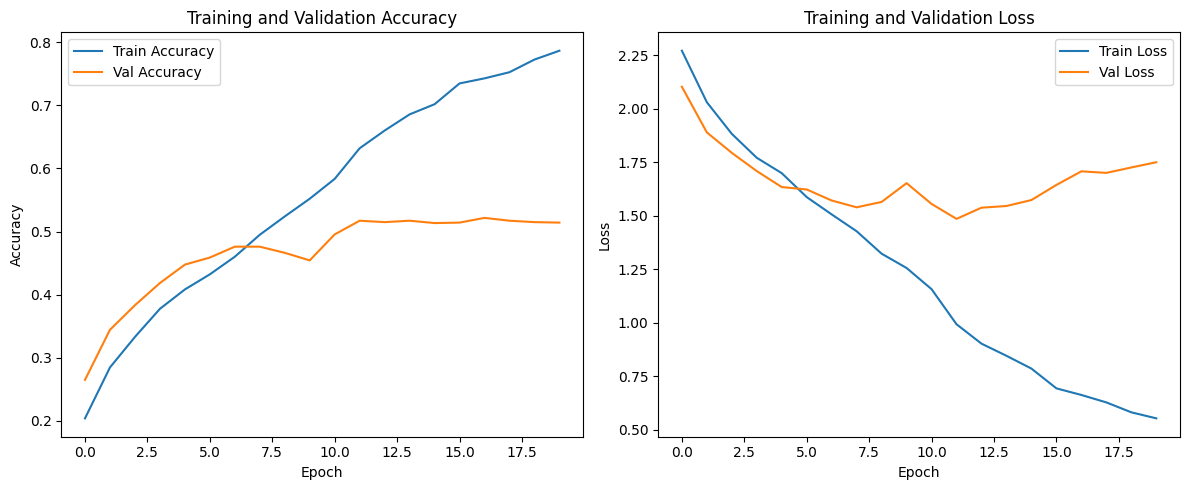

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()